# Pixel Level Calibration

There are a lot of existing frameworks for phase retrieval - but it is not so straightforward to simultaneously retrieve 

- aberrations (the optical distortions, maybe tens of parameters)
- astrometry (the positions of stars, tens of parameters)
- interpixel sensitivity (aka the 'flat field', on a large pixel grid!)

The dimensionality of the pixel grid can be so high it is hard to retrieve without autodiff. With `dLux`, it is easy*!

\* This is the topic of a Desdoigts et al paper in prep. It wasn't quite that easy to build and we're pretty happy about it.

First, import everything as usual:

In [1]:
import jax
import jax.numpy as np
import equinox as eqx
import optax
from tqdm.notebook import tqdm
import numpy as onp
import matplotlib.pyplot as plt

# dLux functions
import dLux as dl
from dLux.utils.zernike import zernike_basis
from dLux.utils import norm_rand, unif_rand
from dLux.utils.models import toliman_layers # pre-built Toliman pupils

# configure plots 
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Then we generate an array of 5 dithered images, in a coarsely-sampled broad bandwidth, of 15 stars. The reason we want multiple stars, and especially dithered images, is because we want to retrieve the _flat field_ - multiplicative errors on each pixel that, if we only have the one image, are formally degenerate with the PSF. It turns out that if we *can* hit each pixel with light from the same PSF multiple times, we can retrieve the whole thing unambiguously.

In [2]:
Nstars = 15
Nims = 5
Nwavels = 3

onp.random.seed(3)
positions = 1e-4*(2*unif_rand([Nstars, 2])-1)
fluxes = norm_rand(1e8, 1e7, Nstars)
wavels = 1e-9 * np.linspace(545, 645, Nwavels)
dithers = 1e-5 * np.array([[0,   0],
                           [+1, +1],
                           [+1, -1],
                           [-1, +1],
                           [-1, -1]])

We will use the presaved default Toliman pupil - a diffractive pupil that nicely spreads out the PSF in a highly structured pattern, designed (with `dLux`) to be ideal for astrometry and field calibration.

We will then add some Zernike mode aberrations on top of this, and have some 5% level flat field calibration errors, and additive background noise. 

In [3]:
# Base layers
lays = toliman_layers()
aperture = lays[2].array
wf_npix = aperture.shape[0]
det_npix = lays[-1].pixels_out

# Load mask
mask = np.load("files/test_mask.npy") * (wavels.mean()/(2*np.pi)) # tinytol pupil design

# Zernike Basis
zern_basis = zernike_basis(10, wf_npix, outside=0.)[3:]
zcoeffs = 2.5e-8 * norm_rand(0, 0.5, len(zern_basis))

pix_response = norm_rand(1, 0.05, [det_npix, det_npix])
det_layers = [dl.ApplyPixelResponse(pix_response)]
BG_noise = np.abs(norm_rand(0, 5, [Nims, det_npix, det_npix]))

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


Turn these into an `OpticalSystem` object:

In [4]:
# Test Osys
layers = toliman_layers([
                dl.ApplyOPD(mask),
                dl.ApplyBasisOPD(zern_basis, zcoeffs)])

osys = dl.OpticalSystem(layers, 
                        wavels=wavels, 
                        positions=positions, 
                        fluxes=fluxes,
                        dithers=dithers,
                        detector_layers=det_layers)

Generate the dithered, noisy images:

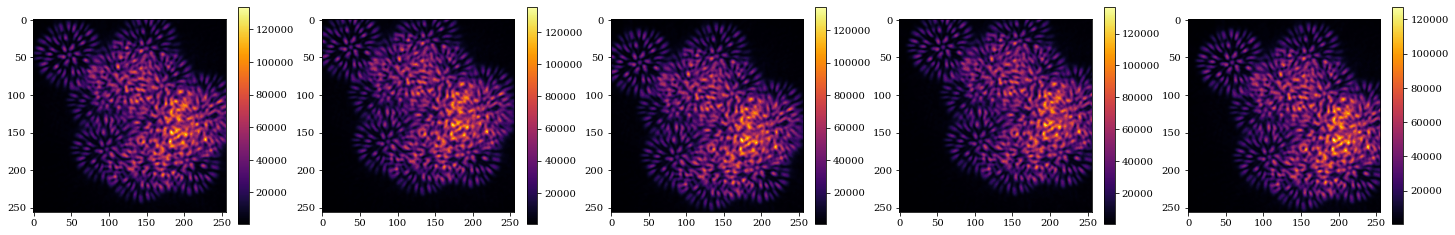

In [5]:
psfs = onp.random.poisson(osys()) + BG_noise
data = psfs

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i])
    plt.colorbar()
plt.show()

Now we are going to initialize a model with zero aberrations, positions and fluxes close to but not exactly like the initialized ones, and flat pixel response.

In [6]:
# Construct initial model
coeffs_init = np.zeros([len(zern_basis)])
positions_init = positions + 0.5e-6*norm_rand(0, 0.2, [Nstars, 2])
fluxes_init = fluxes * norm_rand(1, 0.1, [Nstars])
det_layers_init = [dl.ApplyPixelResponse(np.ones([det_npix, det_npix]))]

layers = toliman_layers([
                dl.ApplyOPD(mask),
                dl.ApplyBasisOPD(zern_basis, coeffs_init)])

opt_model = dl.OpticalSystem(layers, 
                        wavels=wavels, 
                        positions=positions_init, 
                        fluxes=fluxes_init,
                        dithers=dithers,
                        detector_layers=det_layers_init)

The residuals are pretty bad:

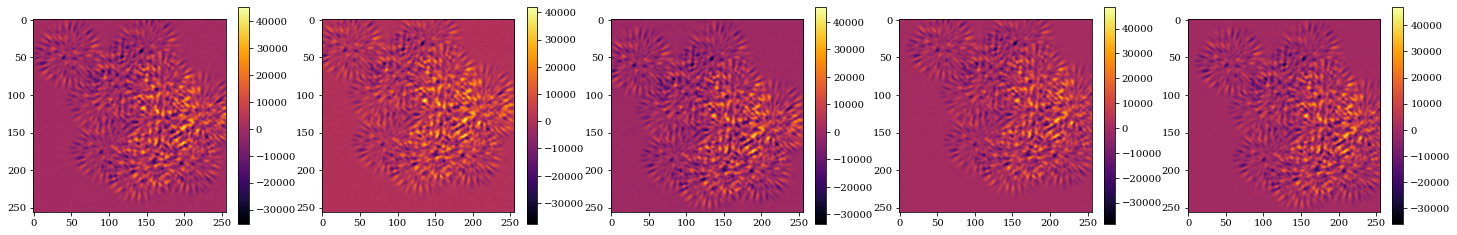

In [7]:
psfs = opt_model()

plt.figure(figsize=(25, 4))
for i in range(len(psfs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(psfs[i] - data[i])
    plt.colorbar()
plt.show()

Now we can start to optimize. Let's set up the `equinox` required filter spec, so we are optimizing positions, fluxes, Zernikes, and flat field:

In [8]:
model = [opt_model]

# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, model)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda osys: osys[0].positions,                         filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].fluxes,                            filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].layers[-2].coeffs,                 filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda osys: osys[0].detector_layers[0].pixel_response, filter_spec, replace=True)

Poisson log-likelihood:

In [9]:
@eqx.filter_jit
@eqx.filter_value_and_grad(arg=filter_spec)
def loss_func(model, data):
    out = model[0]()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Call once to jit compile:

In [10]:
%%time
loss, grads = loss_func(model, data) # Compile

print("Initial Loss: {}".format(int(loss)))

Initial Loss: 195327264
CPU times: user 4.11 s, sys: 189 ms, total: 4.3 s
Wall time: 1.43 s


Initialize `optax` optimizer:

In [11]:
param_spec =  jax.tree_map(lambda _: "null", model)

# Set parameter groups
param_spec = eqx.tree_at(lambda osys: osys[0].positions,                         
                         param_spec, replace='positions')
param_spec = eqx.tree_at(lambda osys: osys[0].fluxes,                            
                         param_spec, replace='fluxes')
param_spec = eqx.tree_at(lambda osys: osys[0].layers[-2].coeffs,                 
                         param_spec, replace='coeffs')
param_spec = eqx.tree_at(lambda osys: osys[0].detector_layers[0].pixel_response, 
                         param_spec, replace='FF')

# Set LRs
pos_lr   = 2e-8
flux_lr  = 1e6
coeff_lr = 2e-9
FF_lr    = 1e-2

FF_init  = 100
FF_sched = optax.piecewise_constant_schedule(init_value=1e-8*FF_lr, 
                                             boundaries_and_scales={FF_init :int(1e8)})

optim = optax.multi_transform(
    {"null":        optax.adam(0.0),
     "positions":   optax.adam(pos_lr),
     "fluxes":      optax.adam(flux_lr),
     "coeffs":      optax.adam(coeff_lr),
     "FF":          optax.adam(FF_sched)},
    param_spec)

opt_state = optim.init(model)

Run gradient descent:

In [12]:
errors, grads_out, models_out = [], [], []

model_out = [opt_model] # Re-initialise Model

with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 

        loss, grads = loss_func(model_out, data)    

        updates, opt_state = optim.update(grads, opt_state)
        model_out = eqx.apply_updates(model_out, updates)
        errors.append(loss)
        grads_out.append(grads)
        models_out.append(model_out)
    
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Format the output into arrays:

In [13]:
nepochs = len(models_out)
psfs_out = model_out[0]()

positions_found = np.array([models_out[i][0].positions                          
                            for i in range(nepochs)])
fluxes_found =    np.array([models_out[i][0].fluxes                             
                            for i in range(nepochs)])
coeffs_found =    np.array([models_out[i][0].layers[-2].coeffs                  
                            for i in range(nepochs)])
prs_found =       np.array([models_out[i][0].detector_layers[0].pixel_response  
                            for i in range(nepochs)])

Pull out the quantities to be plotted - eg final model and residuals:

In [14]:
final_model = model_out[0]
errors = np.array(errors)

coeff_residuals = zcoeffs - coeffs_found
flux_residuals = fluxes - fluxes_found

scaler = 1e3
positions_residuals = positions - positions_found
r_residuals_rads = np.hypot(positions_residuals[:, :, 0], positions_residuals[:, :, 1])
r_residuals = dl.utils.rad2arcsec(r_residuals_rads)

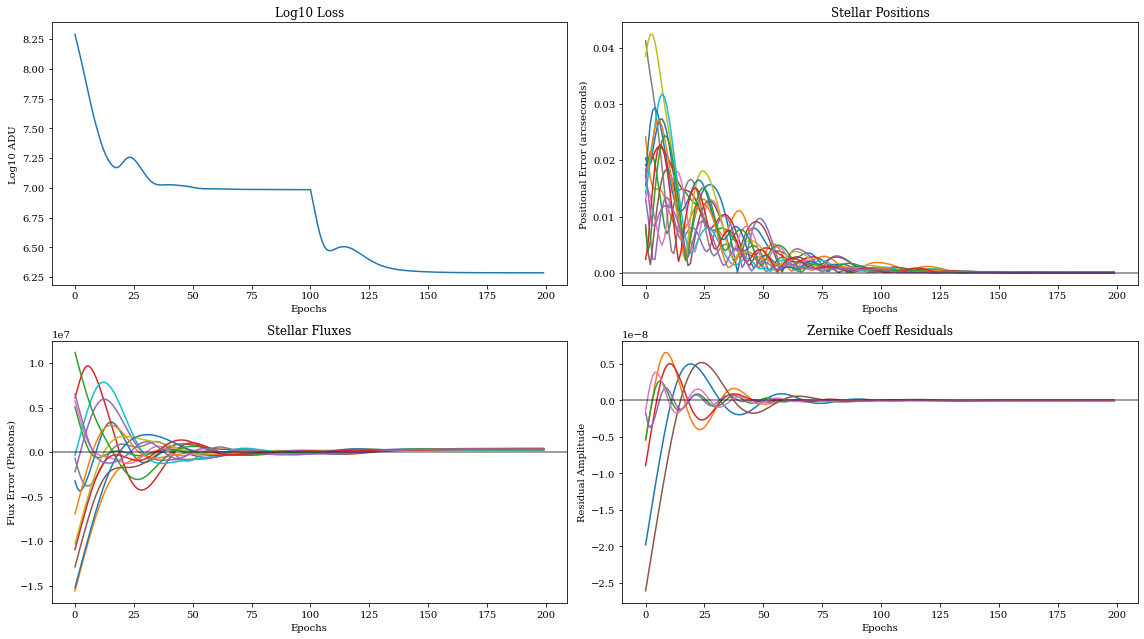

In [15]:
j = len(models_out)
plt.figure(figsize=(16, 13))

plt.subplot(3, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(errors[:j]))

plt.subplot(3, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 3)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(flux_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(3, 2, 4)
plt.title("Zernike Coeff Residuals")
plt.xlabel("Epochs")
plt.ylabel("Residual Amplitude")
plt.plot(coeff_residuals[:j])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()

How did the phase retrieval go? Really well, as it happens!

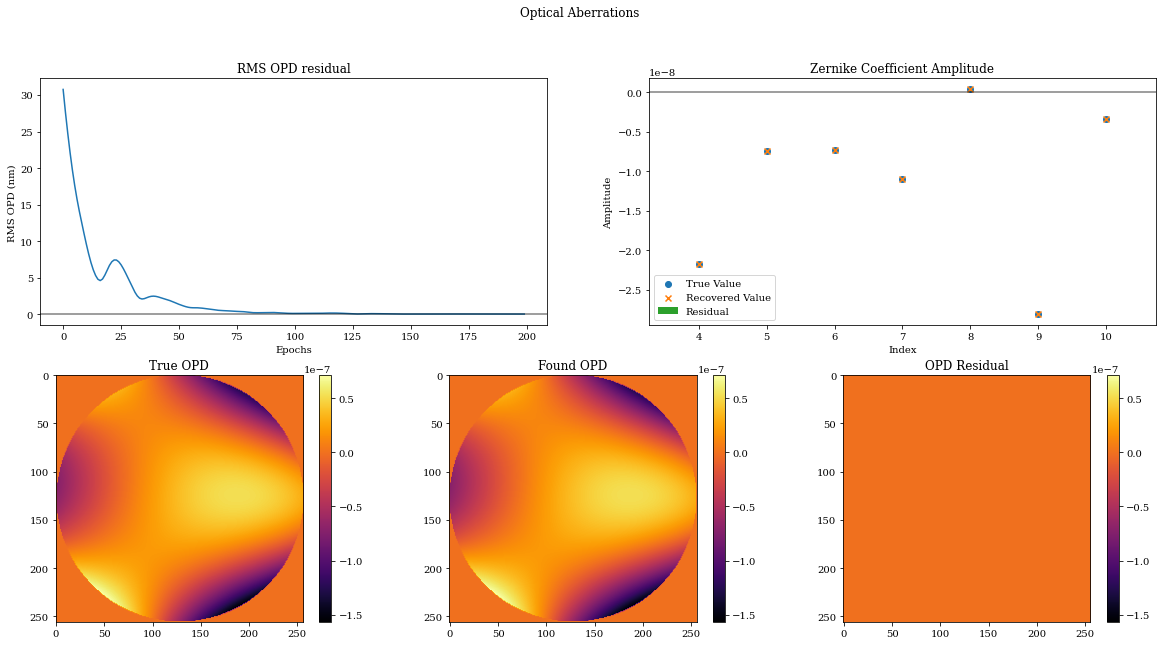

In [16]:
# OPDs
true_opd = osys.layers[-2].get_total_opd()
opds_found = np.array([models_out[i][0].layers[-2].get_total_opd()  for i in range(len(models_out))])
found_opd = opds_found[-1]
opd_residuls = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuls**2, axis=(-1,-2))**0.5

vmin = np.min(np.array([true_opd, found_opd]))
vmax = np.max(np.array([true_opd, found_opd]))

# Coefficients
true_coeff = osys.layers[-2].coeffs
found_coeff = final_model.layers[-2].coeffs
index = np.arange(len(true_coeff))+4

plt.figure(figsize=(20, 10))
plt.suptitle("Optical Aberrations")

plt.subplot(2, 2, 1)
plt.title("RMS OPD residual")
plt.xlabel("Epochs")
plt.ylabel("RMS OPD (nm)")
plt.plot(opd_rmse_nm)
plt.axhline(0, c='k', alpha=0.5)

plt.subplot(2, 2, 2)
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value")
plt.scatter(index, found_coeff, label="Recovered Value", marker='x')
plt.bar(index, true_coeff - found_coeff, label='Residual')
plt.axhline(0, c='k', alpha=0.5)
plt.legend()

plt.subplot(2, 3, 4)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("OPD Residual")
plt.imshow(true_opd - found_opd, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

Most impressively, we are getting the tens of thousands of parameters of the flat field pretty well too!

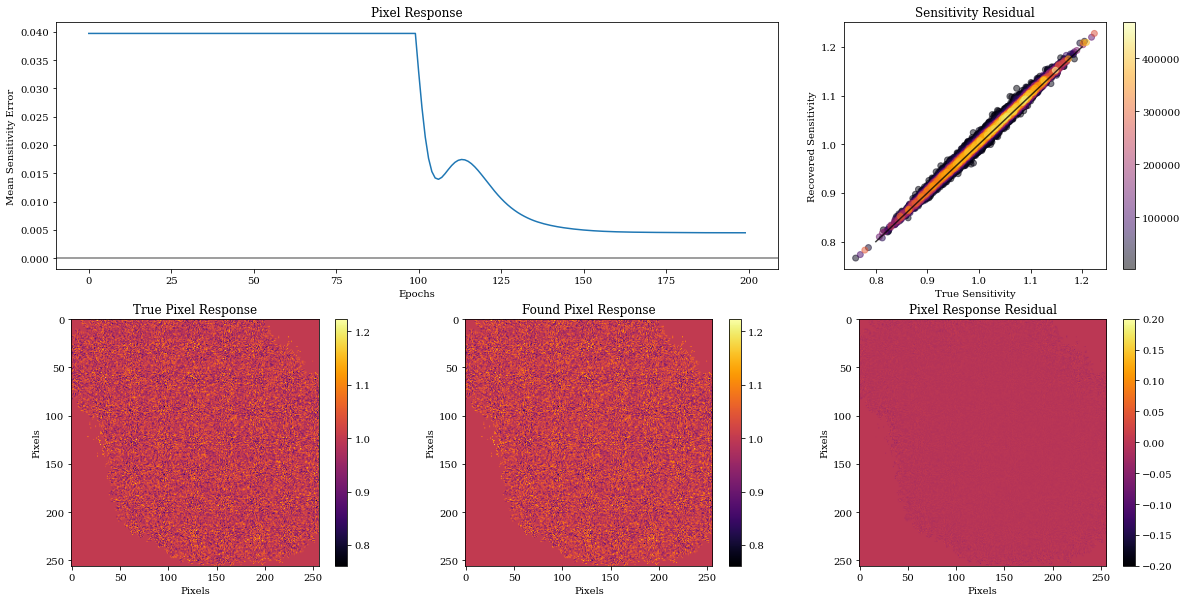

In [17]:
# calculate the mask where there was enough flux to infer the flat field
thresh = 2500
fmask = data.mean(0) >= thresh

out_mask = np.where(data.mean(0) < thresh)
in_mask = np.where(data.mean(0) >= thresh)

data_tile = np.tile(data.mean(0), [len(models_out), 1, 1])
in_mask_tiled = np.where(data_tile >= thresh)

# calculate residuals
pr_residuals = pix_response[in_mask] - prs_found[-1][in_mask]

# for correlation plot
true_pr_masked = pix_response.at[out_mask].set(1)
found_pr_masked = prs_found[-1].at[out_mask].set(1)

# FF Scatter Plot
data_sum = data.sum(0) # [flux_mask]
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

# Errors
pfound = prs_found[in_mask_tiled].reshape([len(models_out), len(in_mask[0])])
ptrue = pix_response[in_mask]
pr_res = ptrue - pfound
masked_error = np.abs(pr_res).mean(-1)

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, (1,2))
plt.title("Pixel Response")
plt.xlabel("Epochs")
plt.ylabel("Mean Sensitivity Error")
plt.plot(masked_error)
plt.axhline(0, c='k', alpha=0.5)

# FF Scatter Plot
data_sum = data.sum(0)
colours = data_sum.flatten()
ind = np.argsort(colours)
colours = colours[ind]

pr_true_flat = true_pr_masked.flatten()
pr_found_flat = found_pr_masked.flatten()

pr_true_sort = pr_true_flat[ind]
pr_found_sort = pr_found_flat[ind]

plt.subplot(2, 3, 3)
plt.plot(np.linspace(0.8, 1.2), np.linspace(0.8, 1.2), c='k', alpha=0.75)
plt.scatter(pr_true_sort, pr_found_sort, c=colours, alpha=0.5)
plt.colorbar()
plt.title("Sensitivity Residual")
plt.ylabel("Recovered Sensitivity")
plt.xlabel("True Sensitivity")

plt.subplot(2, 3, 4)
plt.title("True Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked)
plt.colorbar()

vmin = np.min(pix_response)
vmax = np.max(pix_response)

plt.subplot(2, 3, 5)
plt.title("Found Pixel Response")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(found_pr_masked, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.title("Pixel Response Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(true_pr_masked - found_pr_masked, vmin=-0.2, vmax=0.2)
plt.colorbar()

plt.show()